## Modelling Lending Club Challenge

#### Author: Filip Michalsky, October 22, 2018

**Executive Summary**

**Overview**

We prepared our data set using traditional data science techniques and trained our model (Logistic Regression) to predict whether a loan would default. The definition of loan default was taken from the Challenge Part 1. We evaluated our models used Confusion Matrix and Receiver-Operating Characteristic (ROC) curve to understand the trade-off between false-positives and true positives.

**Findings**

The data set used was very imbalanced, with majority of loans not defaulting (~82%). Thus, the initial model was not useful for predicting which loans will default, as the precision (i.e., loans predicted NOT default will actually default) was low (only 52%) and thus not useful from the business standpoint. Interestingly, interest rate and loan amount proved to not be statistically significant in predicting whether a loan will default via a bootstrap analysis.

After performing cross-validation over a space of regularization parameters and introducing class weights, we were able to improve the ROC of our model while changing false positive rate/ false negative rate ratio (FPR/FNR) and also allowed us to introduce **strategy tuning** of our machine learning model - this way, the business stakeholders can choose the trade-off between number of "good loans" classified as "good" and thus to invest (recall in this case) and precision - how many people who will default are currently predicted to default? 

Ultimately, this **strategy tuning** allowed us to align with a particular loan strategy - do we want to have a safe strategy, where we barely give out loans to anyone who might default BUT miss out on some of the potential revenue, or are we risk-takers who are willing to accept a certain degree of defaults while increasing revenue from 'good' loans? This also depends on the trade-off between how many loans need to perform to satisfy one default, but such analysis was not conducted due to time constraints and could be discussed with the business stakeholder in the future.

For detailed analysis and graphs, please see model evaluation section in the end of this notebook.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

## prepare data for modeling

In [2]:
# Same as in part 1 of the Challenge, we will pre-process the data

In [3]:
df_loan = pd.read_csv("lending-club-loan-data/loan.csv",low_memory=False)

In [4]:
# per instruction, only use these cols 
cols_keep = ['loan_amnt','funded_amnt','term','int_rate','grade',\
            'annual_inc','issue_d','dti','revol_bal','total_pymnt',\
            'loan_status']

In [5]:
df_loan.columns;

In [6]:
df_loan = df_loan.loc[:,cols_keep]

In [7]:
df_loan.shape

(887379, 11)

In [8]:
# Method to impute missing values from continuous variables using k-means clustering
def kmeans_missing(X, n_clusters, max_iter=10):

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            cls = KMeans(n_clusters, n_init=1,n_jobs=-1)

        # Perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # Fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # When the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return X_hat

In [9]:
df_loan.loc[:,['annual_inc']] = kmeans_missing(df_loan.loc[:,['annual_inc']],n_clusters=10,max_iter=10) # this will only work for numerical columns!

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: RuntimeWarning:

Explicit initial center position passed: performing only one init in k-means instead of n_init=10



In [10]:
# ==================================
# Column summaries
# ==================================
#data = train_df

def get_meta_data(data):
    # Define metrics to be determined for each column
    metrics = []
    metrics.append(data.dtypes)
    metrics.append(data.apply(lambda x: x.nunique(), axis=0))
    
    metrics.append(data.apply(lambda x: x.isnull().sum(), axis=0))

    metrics.append(data.apply(lambda x: (x==" ").sum(), axis=0))

    # Summarize
    data_meta = pd.concat(metrics, axis=1)
    data_meta.columns = ['data_type', 'count_unique', 'count_null', 
                         'count_blank']
    # we DO NOT WANT TO COUNG BLANK AS MISSING HERE
#     data_meta['ppn_missing'] = (data_meta['count_null'] + 
#                                 data_meta['count_missing_passive'] + 
#                                 data_meta['count_missing_confirmed'] + 
#                                 data_meta['count_blank']) / len(data)
    data_meta['ppn_missing'] = (data_meta['count_null'] 
                                ) / len(data)
    return data_meta

In [11]:
meta = get_meta_data(df_loan)
meta

,data_type,count_unique,count_null,count_blank,ppn_missing
loan_amnt,float64,1372,0,0,0.0
funded_amnt,float64,1372,0,0,0.0
term,object,2,0,0,0.0
int_rate,float64,542,0,0,0.0
grade,object,7,0,0,0.0
annual_inc,float64,49385,0,0,0.0
issue_d,object,103,0,0,0.0
dti,float64,4086,0,0,0.0
revol_bal,float64,73740,0,0,0.0
total_pymnt,float64,506726,0,0,0.0


In [12]:
# issue date convert to pandas daretime object
df_loan['issue_d']=pd.to_datetime(df_loan['issue_d'])

In [13]:
# convert to categorical where appropriate
cols_categorical = ['term','grade','loan_status']
for c in cols_categorical:
    df_loan[c] = df_loan[c].astype('category')

In [14]:
df_loan['issue_year'] = df_loan.issue_d.dt.year

In [15]:
continuous = [col for col in df_loan.columns if df_loan[col].dtype in ['float64','int64']]

In [16]:
continuous.remove('issue_year')

In [18]:
# continuous features
continuous

['loan_amnt',
 'funded_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'revol_bal',
 'total_pymnt']

In [19]:
categorical = df_loan.columns.difference(continuous+['issue_d'])

In [20]:
categorical = categorical.tolist()

In [21]:
# categorical features
categorical

['grade', 'issue_year', 'loan_status', 'term']

## Create 'default_loan' category as per part 2)

Here, we pre-process our data in the same way as in the first part of the Challenge

In [22]:
df_loan.term.unique()[0]

' 36 months'

In [23]:
df_loan.term = df_loan.term.apply(lambda x: x.strip(' '))

In [24]:
df_36 = df_loan.loc[df_loan.term=='36 months',:]

In [25]:
df_36.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,issue_year
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,Fully Paid,2011
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,Fully Paid,2011
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,Fully Paid,2011
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,11.20,7963.0,5631.377753,Fully Paid,2011
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,5.35,8221.0,3938.144334,Fully Paid,2011


In [26]:
print(f'we have {df_36.shape[0]} of 36 months term loans available for analysis.')

we have 621125 of 36 months term loans available for analysis.


Exclude loans with less than 36 months of data available:

I look at the latest date in the dataset and assume that is the most 'current date'

Then I exlude loans which were issued after (maximum_date - 36 months) to get only loans with 36 months or more worth of data

In [27]:
cutoff_date = np.max(df_36.issue_d) - pd.Timedelta(weeks=36*4)
print(f'Exclude loans issued after {cutoff_date}')

Exclude loans issued after 2013-02-26 00:00:00


In [28]:
df_36 = df_36.loc[df_36.issue_d<=cutoff_date,:]

In [29]:
print(f'Latest loan with 36 months worth of data in current dataset issued on {df_36.issue_d.max()}')

Latest loan with 36 months worth of data in current dataset issued on 2013-02-01 00:00:00


In [30]:
# cast df to old namespace
import gc
del df_loan
gc.collect() # clean memory (python garbage collector)
df_loan = df_36.copy(deep=True)

In [31]:
df_loan.term.value_counts()

36 months    86552
60 months        0
Name: term, dtype: int64

In [32]:
# drop term since we are only looking at 36 months loans
df_loan = df_loan.drop('term',axis=1)

In [33]:
## create feature indicating whether loan defaulted or not
# convert loan status to binary good/bad loans

fully_paid = ["Fully Paid"]

df_loan['defaulted_loan'] = np.nan

def loan_condition(status):
    if status in fully_paid:
        return 'Paid'
    else:
        return 'Defaulted'
    
    
df_loan['defaulted_loan'] = df_loan['loan_status'].apply(loan_condition)

df_loan["defaulted_loan_int"] = df_loan["defaulted_loan"].apply(lambda x: 0 if x== 'Paid' else 1)

In [34]:
print(f'Percentage of loans fully paid: {np.round(df_loan.loan_status[df_loan.loan_status=="Fully Paid"].count()/df_loan.loan_status.count(),3)*100}%')

Percentage of loans fully paid: 81.5%


In [35]:
df_loan.head()

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,issue_year,defaulted_loan,defaulted_loan_int
0,5000.0,5000.0,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,Fully Paid,2011,Paid,0
2,2400.0,2400.0,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,Fully Paid,2011,Paid,0
3,10000.0,10000.0,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,Fully Paid,2011,Paid,0
5,5000.0,5000.0,7.90,A,36000.0,2011-12-01,11.20,7963.0,5631.377753,Fully Paid,2011,Paid,0
7,3000.0,3000.0,18.64,E,48000.0,2011-12-01,5.35,8221.0,3938.144334,Fully Paid,2011,Paid,0


In [36]:
# look at correlations in the data set

In [37]:
df_correlations = df_loan.corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

funded_amnt and loan_amnt suffer from collinearity! We will need to address that (at least) via regularization of our model.

As expected, the default status is strongly negatively correlated with total payment made on the loan.

In [38]:
df_loan['diff_loan_funded']= df_36.loan_amnt.values-df_loan.funded_amnt.values

In [39]:
print(f'There is only {sum(df_loan["diff_loan_funded"]>0)} loans which had a difference between loan amnt and funded amount.')

There is only 871 loans which had a difference between loan amnt and funded amount.


In [40]:
df_loan.columns

Index(['loan_amnt', 'funded_amnt', 'int_rate', 'grade', 'annual_inc',
       'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status',
       'issue_year', 'defaulted_loan', 'defaulted_loan_int',
       'diff_loan_funded'],
      dtype='object')

In [41]:
# drop cols we will not use
# date (we will only use year)
df_loan.drop(['loan_status','defaulted_loan','diff_loan_funded','issue_d'],axis=1,inplace=True)


In [42]:
df_loan.head()

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,dti,revol_bal,total_pymnt,issue_year,defaulted_loan_int
0,5000.0,5000.0,10.65,B,24000.0,27.65,13648.0,5861.071414,2011,0
2,2400.0,2400.0,15.96,C,12252.0,8.72,2956.0,3003.653644,2011,0
3,10000.0,10000.0,13.49,C,49200.0,20.00,5598.0,12226.302212,2011,0
5,5000.0,5000.0,7.90,A,36000.0,11.20,7963.0,5631.377753,2011,0
7,3000.0,3000.0,18.64,E,48000.0,5.35,8221.0,3938.144334,2011,0


In [43]:
df_loan['defaulted_loan_int'] = df_loan['defaulted_loan_int'].astype('category')
'''
note : including issue_year as a feature might be problematic from a business standpoint,
as we would like to predict on new loans in the future - thus, I decided to drop the year
'''
df_loan.drop('issue_year',axis=1,inplace=True)
#df_loan['issue_year'] = df_loan['issue_year'].astype('category')

In [44]:
df_loan.dtypes

loan_amnt              float64
funded_amnt            float64
int_rate               float64
grade                 category
annual_inc             float64
dti                    float64
revol_bal              float64
total_pymnt            float64
defaulted_loan_int    category
dtype: object

In [45]:
# standardize continuous variables and get dummies for categorical
df_loan.loc[:,continuous].head()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
0,5000.0,5000.0,10.65,24000.0,27.65,13648.0,5861.071414
2,2400.0,2400.0,15.96,12252.0,8.72,2956.0,3003.653644
3,10000.0,10000.0,13.49,49200.0,20.00,5598.0,12226.302212
5,5000.0,5000.0,7.90,36000.0,11.20,7963.0,5631.377753
7,3000.0,3000.0,18.64,48000.0,5.35,8221.0,3938.144334


In [46]:
df_loan.loc[:,df_loan.columns.difference(continuous)].head()

,defaulted_loan_int,grade
0,0,B
2,0,C
3,0,C
5,0,A
7,0,E


In [47]:
# check fr missing values in the dataframe one more time
df_loan.isnull().any().any()

False

In [48]:
# deploy stratified train/test split to make sure we have a similar proportion
# of defaulted loans in both train/test sets
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_loan,test_size=0.25,stratify = df_loan['defaulted_loan_int'])

print('Train set ratio \n', train["defaulted_loan_int"].value_counts()/len(train))
print('Test set ratio \n', test["defaulted_loan_int"].value_counts()/len(test))

Train set ratio 
 0    0.814724
1    0.185276
Name: defaulted_loan_int, dtype: float64
Test set ratio 
 0    0.814724
1    0.185276
Name: defaulted_loan_int, dtype: float64


In [49]:
x_train = train.drop('defaulted_loan_int',axis=1)
y_train = train['defaulted_loan_int']

x_test = test.drop('defaulted_loan_int',axis=1)
y_test = test['defaulted_loan_int']

In [50]:
# check dimensions
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(64914, 8) (64914,) (21638, 8) (21638,)


In [51]:
# now, we standardize our continuous variables

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler()

In [54]:
x_train.loc[:,continuous].columns,x_test.loc[:,continuous].columns

(Index(['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti',
        'revol_bal', 'total_pymnt'],
       dtype='object'),
 Index(['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti',
        'revol_bal', 'total_pymnt'],
       dtype='object'))

In [55]:
scaler.fit(x_train.loc[:,continuous])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
x_train.loc[:,continuous] = scaler.fit_transform(x_train.loc[:,continuous])

In [57]:
# we make sure to standardize test set columns with mean and std of cols from the training test (to prevent information bleed)
x_test.loc[:,continuous] = scaler.fit_transform(x_test.loc[:,continuous])

In [58]:
x_test.head()

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,dti,revol_bal,total_pymnt
40975,-1.261596,-1.258555,1.031034,D,0.401458,1.225099,1.085265,-1.124496
209813,-0.341435,-0.334739,-0.287566,B,-0.548811,1.025096,-0.000849,-0.218189
173167,0.197110,0.205944,-0.021676,B,-0.300474,1.986698,-0.272878,0.344657
177420,1.409726,1.423376,-1.513920,A,0.667533,1.621130,4.349111,1.336986
183686,0.125779,0.134331,-0.021676,B,-0.168704,0.756219,0.168425,0.272535


In [59]:
# one-hot encoding of categorical variables
# we need to concatenate and then split x_train,x_test again (to ensure same categories)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(64914, 8) (64914,) (21638, 8) (21638,)


In [60]:
data = pd.concat((x_train,x_test))

In [61]:
data.shape

(86552, 8)

In [62]:
data_one_hot = pd.get_dummies(data)

In [63]:
x_train = data_one_hot.iloc[:x_train.shape[0],:]
x_test = data_one_hot.iloc[x_train.shape[0]:,:]

In [64]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(64914, 14) (64914,) (21638, 14) (21638,)


In [65]:
# difference in columns train/test sets
set(x_train.columns)^set(x_test.columns)

set()

In [66]:
x_train.head()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
15912,-0.933563,-0.929704,-0.331353,-0.344336,-0.840910,-0.647720,-0.806598,0,1,0,0,0,0,0
28596,0.682906,0.691082,0.686468,0.547026,0.270383,0.278637,0.914853,0,0,1,0,0,0,0
212856,-1.254009,-1.251005,-0.666988,-0.631526,0.283708,-0.034693,-1.129293,0,1,0,0,0,0,0
4369,-0.314036,-0.308521,-1.523813,-0.578833,1.412324,-0.042456,-0.571495,1,0,0,0,0,0,0
210929,-0.228583,-0.222841,-0.023005,0.889857,1.450966,0.861211,-0.086867,0,1,0,0,0,0,0


In [208]:
# save pre-processed data
x_train.to_csv('lending-club-loan-data/x_train_preprocessed.csv')
y_train.to_csv('lending-club-loan-data/y_train_preprocessed.csv')
x_test.to_csv('lending-club-loan-data/x_test_preprocessed.csv')
y_test.to_csv('lending-club-loan-data/x_test_preprocessed.csv')

## Modeling and Evaluation

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [68]:
# try baseline logistic regression without sample weighting or cross-validation of parameters

In [183]:
## DO NOT RUN THIS CELL (will not work as I threw out year from previous cells for reasons stated above)
run_this = False
    if run_this:
    logreg = LogisticRegression(C=100000, fit_intercept=False,solver='lbfgs')
    logreg.fit(x_train, y_train)

    # output 
    y_train_pred = logreg.predict(x_train)
    y_test_pred = logreg.predict(x_test)

    train_score_logreg = accuracy_score(y_train, y_train_pred)
    test_score_logreg = accuracy_score(y_test, y_test_pred)

    print("train score:", train_score_logreg, "test score:", test_score_logreg, 'with year as a feature.')

train score: 0.9042271312813877 test score: 0.9040576763101951 with year as a feature.


In [69]:
logreg = LogisticRegression(C=100000, fit_intercept=False,solver='lbfgs')
logreg.fit(x_train, y_train)
 
# output 
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

train_score_logreg = accuracy_score(y_train, y_train_pred)
test_score_logreg = accuracy_score(y_test, y_test_pred)

print("train score:", train_score_logreg, "test score:", test_score_logreg, 'without year as a feature.')

train score: 0.91082047016052 test score: 0.9124688048803031 without year as a feature.


This is a pretty decent accuracy of this out-of-the box model. This means that 91% of all applicants were correctly classified in default/will not default buckets. **But be careful!** We have a highly imbalanced dataset, thus accuracy alone does not speak enough about the "quality" of our model.

Also, we actually improved without including the year as a feature! This is likely due to the imbalance of origination years among train/test sets.

Let's look at other characteristics, such as the confusion matrix, to really understand the model.

In [70]:
import sklearn.metrics as metrics
from tqdm import tqdm_notebook as tqdm
import itertools

## perform bootstrap to see how many and which features are significant at 95% significance level.

In [227]:
# bootstrapping code

n = 200 # Number of iterations
boot_coefs = np.zeros((x_train.shape[1],n)) # Create empty storage array for later use

# iteration for each sample
for i in tqdm(range(n)):
    # Sampling WITH replacement the indices of a resampled dataset 
    sample_index = np.random.choice(range(y_train.shape[0]), size=y_train.shape[0], replace=True)

    # finding subset
    x_train_samples = x_train.values[sample_index]
    y_train_samples = y_train.values[sample_index]
    
    # finding logreg coefficient
    logistic_mod_boot = LogisticRegression(C=100000, fit_intercept=True,solver='lbfgs',max_iter=300) 
    logistic_mod_boot.fit(x_train_samples, y_train_samples) 
    boot_coefs[:,i] = logistic_mod_boot.coef_

In [230]:
ci_upper = np.percentile(boot_coefs, 97.5, axis=1)
ci_lower = np.percentile(boot_coefs, 2.5, axis=1)

# ct significant predictors
sig_b_ct = 0
sig_preds = []
cols = list(x_train.columns)

# if ci contains 0, then insignificant
for i in range(len(ci_upper)):
    if ci_upper[i]<=0 or ci_lower[i]>=0:
            sig_b_ct += 1
            sig_preds.append(cols[i])

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, len(ci_upper)))
print('Number of significant columns: ', len(sig_preds))

Significant coefficents at 5pct level = 12 / 14
Number of significant columns:  12


In [231]:
set(sig_preds)^set(x_train.columns)

{'int_rate', 'loan_amnt'}

We confirmed that all except interest rates and loan amounts are significant features at 95% significance level for predicting default rates, which is interesting finding! It makes sense as the interest rate and loan amount are things the bank official creates after evaluating the loan applicant.



In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0) #45
    plt.yticks(tick_marks, classes, rotation=90) #0

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[17438   191]
 [ 1703  2306]]


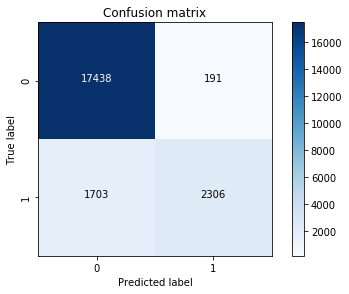

In [72]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_test_pred),classes=['0','1']);

In [73]:
tn_logreg, fp_logreg, fn_logreg, tp_logreg = metrics.confusion_matrix(y_test, y_test_pred).astype('float').ravel()

print("The true positive rate for the logistic regression:",tp_logreg/(tp_logreg + fn_logreg))
print("")
print("The true negative rate for the logistic regression:",tn_logreg/(tn_logreg + fp_logreg))
print("")
print("The false positive rate for the logistic regression:",fp_logreg/(fp_logreg + tn_logreg))
print("")
print("The false negative rate for the logistic regression:",fn_logreg/(tp_logreg + fn_logreg))

The true positive rate for the logistic regression: 0.5752057869792966

The true negative rate for the logistic regression: 0.9891655794429633

The false positive rate for the logistic regression: 0.0108344205570367

The false negative rate for the logistic regression: 0.4247942130207034


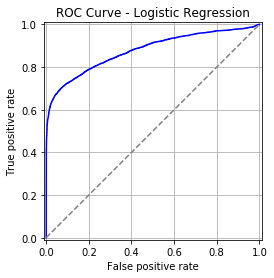

In [77]:
fprs_logreg, tprs_logreg, thresh_logreg = metrics.roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
y_all_normal = np.zeros(len(y_test))

fprs_zeros, tprs_zeros, thresh_zeros = metrics.roc_curve(y_test, y_all_normal)

# Plot the ROC curves
fig1, ax1 = plt.subplots(1, 1)
fig1.set_figwidth(12)

ax1.set_title("ROC Curve - Logistic Regression")
ax1.plot(fprs_logreg, tprs_logreg, color='blue')
ax1.plot([0,1],[0,1], "--", color='grey')
ax1.set( aspect='equal')
ax1.grid(True)
ax1.set_xlim(-0.01,1.01), ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel("False positive rate"), ax1.set_ylabel("True positive rate");

Evaluation: 

our model is really **specific, i.e., has high recall** (HIGH specificity)- this means that the model is great in  classifying correctly people who will actually **not** default in 99% of the test cases.

However, our model is **not sensitive i.e., not precise** in identifying true positives (LOW sensitivity), i.e. it predicts a large amount of loans to NOT default even if they actually **defaulted**. 

This is very problematic. Obviously, bank officials would like to have "safe" predictions - meaning we do not want to lose money on giving loans to people who would default- this model is **BAD** as the false negative rate (i.e., 42% of will-default loans are predicted as will NOT default). 

Now, we will try to improve it by cross-validating the regularization and sample weighting.

In [78]:
weight_not_default = 1
weight_default = 12
logreg = LogisticRegressionCV(Cs=[10,100,100,10000,100000], fit_intercept=True,solver='lbfgs',\
                              max_iter = 200,cv=5,class_weight = {0: weight_not_default, 1: weight_default})
logreg.fit(x_train, y_train)
 
# output 
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

train_score_logreg = accuracy_score(y_train, y_train_pred)
test_score_logreg = accuracy_score(y_test, y_test_pred)

print("train score:", train_score_logreg, "test score:", test_score_logreg, 'without year as a feature.')

train score: 0.6762023600455987 test score: 0.6764488400036972 without year as a feature.


Confusion matrix, without normalization
[[11092  6537]
 [  464  3545]]


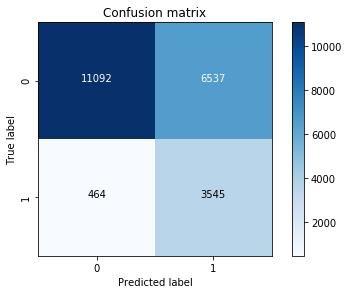

In [79]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_test_pred),classes=['0','1']);

In [80]:
tn_logreg, fp_logreg, fn_logreg, tp_logreg = metrics.confusion_matrix(y_test, y_test_pred).astype('float').ravel()

print("The true positive rate for the logistic regression:",tp_logreg/(tp_logreg + fn_logreg))
print("")
print("The true negative rate for the logistic regression:",tn_logreg/(tn_logreg + fp_logreg))
print("")
print("The false positive rate for the logistic regression:",fp_logreg/(fp_logreg + tn_logreg))
print("")
print("The false negative rate for the logistic regression:",fn_logreg/(tp_logreg + fn_logreg))

The true positive rate for the logistic regression: 0.8842604140683462

The true negative rate for the logistic regression: 0.6291905383175449

The false positive rate for the logistic regression: 0.37080946168245504

The false negative rate for the logistic regression: 0.11573958593165377


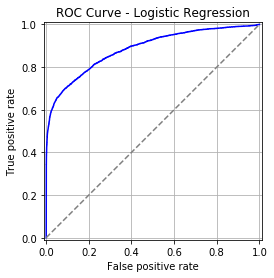

In [81]:
fprs_logreg, tprs_logreg, thresh_logreg = metrics.roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
y_all_normal = np.zeros(len(y_test))

fprs_zeros, tprs_zeros, thresh_zeros = metrics.roc_curve(y_test, y_all_normal)

# Plot the ROC curves
fig1, ax1 = plt.subplots(1, 1)
fig1.set_figwidth(12)

ax1.set_title("ROC Curve - Logistic Regression")
ax1.plot(fprs_logreg, tprs_logreg, color='blue')
ax1.plot([0,1],[0,1], "--", color='grey')
ax1.set( aspect='equal')
ax1.grid(True)
ax1.set_xlim(-0.01,1.01), ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel("False positive rate"), ax1.set_ylabel("True positive rate");

In [82]:
def get_max_tpr(fprs, tprs, thresholds, val):
    # First find the closest value index in fprs to val
    closest_value = max(i for i,v in enumerate(fprs) if v <= val)
    
    # Now, use linear interpolation to calculate corresponding tpr, threshold
    tpr_out = np.interp(val, 
                        (fprs[closest_value],fprs[closest_value+1]),
                       (tprs[closest_value],tprs[closest_value+1]))
    
    thresh_out = np.interp(val, 
                        (fprs[closest_value],fprs[closest_value+1]),
                       (thresholds[closest_value],thresholds[closest_value+1]))
    
    # Now, return the tpr and threshold values at that index
    return tpr_out, thresh_out


print("Using logistic regression:")
for this_fpr in [0, 0.1, 0.5, 0.9]:
    this_tpr, this_thresh = get_max_tpr(fprs_logreg, tprs_logreg, thresh_logreg, this_fpr)
    print("At FPR={:.1f}, TPR~{:.3f}, Threshold~{:.5f}".format(this_fpr, this_tpr, this_thresh))     
print("")
print("Using all zeroes prediction:")
for this_fpr in [0, 0.1, 0.5, 0.9]:
    this_tpr, this_thresh = get_max_tpr(fprs_zeros, tprs_zeros, thresh_zeros, this_fpr)
    print("At FPR={:.1f}, TPR~{:.3f}, Threshold~{:.5f}".format(this_fpr, this_tpr, this_thresh)) 

Using logistic regression:
At FPR=0.0, TPR~0.192, Threshold~0.99991
At FPR=0.1, TPR~0.709, Threshold~0.73704
At FPR=0.5, TPR~0.929, Threshold~0.43733
At FPR=0.9, TPR~0.991, Threshold~0.23512

Using all zeroes prediction:
At FPR=0.0, TPR~0.000, Threshold~1.00000
At FPR=0.1, TPR~0.100, Threshold~0.90000
At FPR=0.5, TPR~0.500, Threshold~0.50000
At FPR=0.9, TPR~0.900, Threshold~0.10000


Evaluation: 

By introducing class weights, we can **tune the model to the 'strategy'** of the bank officials and also **improve** the model characteristics - see the ROC curve for trade-off between true positive and false positive rates. (if more time, we could even search through a number of best class weight pairs and pick the one which maximizes TPR/FPR tradeoff). **Intuitively, we would like to correctly classify as many instances of people who will default.** Here, at the expense of recall (i.e, now, we will predict more 'good loans' to default), we can boost the precision of the model significantly (i.e., we now have many more people who will default as predicted that they will default) by changing the class weights.

More quantitatively, looking at the roc curve and pulling out select values, our model is able to be 92% precise (correctly classify people who will default) if we have false positive rate (do not give loan to people who deserve it) at 50%.

-> It is important to discuss the "risk factors" with the business key stakeholders before deploying such model. For instance, it is very important to know what percentage of loans the business stakeholders can afford to give out to people who would likely default - keeping in mind that the better the model is in correctly classifying defaults, it would eat up potential additional revenue on loans for people who would have not defaulted, but are now predicted as defaults via the model. These trade-offs can be directly read-off the ROC curve OR tabulated (for easier understanding) as in the cell above.

